<a href="https://colab.research.google.com/github/marles77/meta-analysis-colab-python/blob/main/Meta_analysis_rpy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meta-analysis with Python and R via rpy2 package
### Author: Marcin Leśniak
This notebook utilizes [rpy2](https://rpy2.github.io/) Python package which provides an interface to R. Because both Python and R interpreters are installed in Google Colab by default, one can easily embed R functions in Python code.
There are 7 steps to complete meta-analysis in this notebook:
1. [Preparing Python-R binding](#cell-1)
2. [Importing modules](#cell-2)
3. [Preparing data](#cell-3)
4. [Running R metafor functions](#cell-4)
5. [CI and weight calculation](#cell-5)
6. [Creating a forest plot](#cell-6)
7. [Publication bias analysis](#cell-7)

<a name="cell-1"></a>
## 1. Prepare Python-R binding


In [ ]:
# Upgrade rpy2 to the latest version
!pip install rpy2 --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rpy2: filename=rpy2-3.5.13-cp310-cp310-linux_x86_64.whl size=332814 sha256=a8a0eae61720a8fbb4be0549c646d0c5b2a6725bbe1b686d5386f3e887a9ae8a
  Stored in directory: /root/.cache/pip/wheels/b3/10/14/333faaf40f9cd461b2cd5a785a32d593b88e08b1834f081bd5
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [ ]:
# Just checking...
import rpy2, rpy2.situation

for row in rpy2.situation.iter_info():
    print(row)


rpy2 version:
3.5.13
Python version:
3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Looking for R's HOME:
    Environment variable R_HOME: None
    Calling `R RHOME`: /usr/lib/R
    Environment variable R_LIBS_USER: None
R's value for LD_LIBRARY_PATH:
/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
R version:
    In the PATH: R version 4.3.1 (2023-06-16) -- "Beagle Scouts"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/usr/share/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'icuuc', 'icui18n']
  library_dirs:
  ['/usr/lib/R/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '-Wl,-Bsymbolic-functions', '-Wl,-z,relro']
Directory for the R shared library:
lib
CFFI extension type
  Environment variable: RPY2_CFFI_MODE
  Value: CFFI_MODE.ANY
  ABI:

<a name="cell-2"></a>
## 2. Import modules

In [ ]:
# Import Python modules

import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import conversion, default_converter
from rpy2.robjects import pandas2ri

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib.path import Path
import matplotlib.patches as patches

%matplotlib inline


In [ ]:
# Import basic R modules in context manager

with conversion.localconverter(default_converter):
    # import R's "base" package
    base = importr('base')

    # import R's "utils" package
    utils = importr('utils')


In [ ]:
# Install metafor package

with conversion.localconverter(default_converter):
    utils.chooseCRANmirror(ind=1)
    utils.install_packages('metafor')


In [ ]:
# Import metafor

with conversion.localconverter(default_converter):
    metafor = importr('metafor')


<a name="cell-3"></a>
## 3. Prepare data

In [ ]:
# Example data for meta-analysis
# Here we use Hedge's g as effect size and vi as variance
# Standard error of mean will be also used in our calculations

df = pd.DataFrame({
                    'Author': ['Schrute et al. (2023)', 'Goodman et al. (2020)', 'White et al. (2013)', 'Schrute et al. (2023)', 'Targaryen et al. (2021)'],
                    'g': [0.5, 0.35, 0.15, -0.05, 0.8],
                    'vi': [0.1, 0.15, 0.12, 0.17, 0.2],
                    'SE': [0.22, 0.35, 0.3, 0.42, 0.6],
                    'Sample size': [30, 15, 20, 40, 12]
                    })
df

,Author,g,vi,SE,Sample size
0,Schrute et al. (2023),0.50,0.10,0.22,30
1,Goodman et al. (2020),0.35,0.15,0.35,15
2,White et al. (2013),0.15,0.12,0.30,20
3,Schrute et al. (2023),-0.05,0.17,0.42,40
4,Targaryen et al. (2021),0.80,0.20,0.60,12


In [ ]:
# Mount Google Drive if needed

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Change working directory if needed (files will be saved here)

%cd /content/drive/MyDrive/Colab Notebooks/
!pwd


/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Specify the file containing data and read it as Pandas Data Frame

file_name = "myfile.csv"
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/' + file_name, sep=';', encoding='utf-8')
df


<a name="cell-4"></a>
## 4. Run metafor functions

For reference: [metafor](https://wviechtb.github.io/metafor/reference/index.html)



In [ ]:
# Run all metafor functions at once, including meta-analysis and publication bias analysis
# These R-generated objects will be used to create plots

with (default_converter + pandas2ri.converter).context():
    # Meta-analysis
    rma_res = metafor.rma(yi=df['g'], vi=df['vi'], method = "REML")

    # Funnel plot asymetry (used later)
    egger = metafor.regtest(x=df['g'], sei=df['SE'], model="rma", predictor="sei")
    rank_test = metafor.ranktest(x=df['g'], sei=df['SE'])

    # File Drawer Analysis (used later)
    fail_safe = metafor.fsn(yi=df['g'], sei=df['SE'], type="Rosenthal", alpha=.05, weighted=False)

print(rma_res['call'])


Random-Effects Model (k = 5; tau^2 estimator: REML)

tau^2 (estimated amount of total heterogeneity): 0 (SE = 0.0979)
tau (square root of estimated tau^2 value):      0
I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  1.00

Test for Heterogeneity:
Q(df = 4) = 2.5100, p-val = 0.6428

Model Results:

estimate      se    zval    pval   ci.lb   ci.ub    
  0.3425  0.1669  2.0516  0.0402  0.0153  0.6697  * 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




<a name="cell-5"></a>
## 5. Functions for CI and weight calculation

In [ ]:
# CI calculation

def ci_calc(val, se, level=0.95, res='array'):

    """Function calculates lower and upper bounds CI
       val and se can be either floats or arrays of floats
    """

    levels = {0.90: 1.64485,
              0.95: 1.95996,
              0.99: 2.57583}

    z = levels.get(level, 1.95996)

    lb = val - se * z
    ub = val + se * z

    ci = pd.DataFrame({'lb': lb, 'ub': ub}) if res=='df' else np.array([lb, ub])

    return ci


# Weight calculation

def weight_calc(arr_vi, tau2=None, model='RE'):

    """Function calculates weights of studies"""

    if model == 'FE':
        arr_iv = 1 / (arr_vi)
        w = (arr_iv / np.sum(arr_iv)) * 100
        return w

    elif model == 'RE':
        if tau2 != None:
            arr_iv = 1 / (tau2 + arr_vi)
            w = (arr_iv / np.sum(arr_iv)) * 100
            return w
        else:
            return None
    else:
        return None


<a name="cell-6"></a>
## 6. Forest plot

In [ ]:
# Modify Data Frame adding a column with weight and two columns for CI

ci = ci_calc(df['g'], df['SE'], res='df')
weights = weight_calc(df['vi'], tau2=rma_res['tau2'][0], model='RE')
cols = [df, ci, pd.Series(weights, name='w')]
df_merge = pd.concat(cols, axis=1)
df_merge


,Author,g,vi,SE,Sample size,lb,ub,w
0,Schrute et al. (2023),0.50,0.10,0.22,30,0.068809,0.931191,27.868852
1,Goodman et al. (2020),0.35,0.15,0.35,15,-0.335986,1.035986,18.579235
2,White et al. (2013),0.15,0.12,0.30,20,-0.437988,0.737988,23.224044
3,Schrute et al. (2023),-0.05,0.17,0.42,40,-0.873183,0.773183,16.393443
4,Targaryen et al. (2021),0.80,0.20,0.60,12,-0.375976,1.975976,13.934426


<ipython-input-60-adc64a8443d9>:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax2.errorbar(row[es], data_sorted.index.get_loc(i)+1,


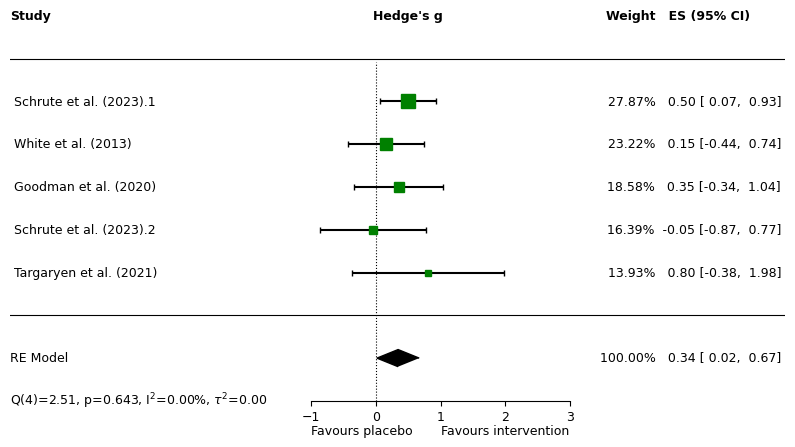

In [ ]:
# Forest plot

def forest_plot(data, rma_res, sortby='w', weight='w', study_label='Author',
                ci_vals={'lower': 'lb', 'upper': 'ub'}, vi='vi', es='g',
                estimate="Hedge's g", ci_label='ES (95% CI)', figsize=(12, 4),
                width_ratios=[0.4, 0.6, 0.4], es_xlim=(-1, 3), vline_ymax=0.93,
                mcolor='green', mecolor='green', mratio=1, fontsize=10,
                fontname='sans-serif', cond_labels=('placebo', 'intervention'),
                cond_labels_vadj=-0.05, incl_details=False, filename=None,
                filetype=None, filedpi=100)->None:

    """Function creates a forest plot

       Parameters
       ----------
       data: DataFrame, required
           Includes columns with effect sizes and variability specified as
           column names in parameters 'es' and 'vi'
       rma_res: rma object generated by R metafor, required
           Includes results of meta-analysis (overall effect size, CI,
           heterogeneity statistics)
       ...
    """

    RE_MODELS = {"DL", "HE", "HS", "HSk", "SJ", "ML", "REML", "EB", "PM", "GENQ", "PMM", "GENQM"}

    # Prepare data - sort, add numbers to duplicate study labels, create an array of indices
    data_sorted = data.sort_values(sortby, ascending=False) # temporary sort to add numbers
    data_sorted[study_label] = np.where(data_sorted[study_label].duplicated(keep=False),
                                        data_sorted[study_label] + '.' + data_sorted.groupby(study_label).cumcount().add(1).astype(str),
                                        data_sorted[study_label])
    data_sorted = data_sorted.sort_values(sortby, ascending=True) # final sort

    ind = np.arange(1, len(data_sorted.index)+1)

    model_label = 'RE Model' if list(rma_res['method'])[0] in RE_MODELS else 'FE Model'
    ylim = len(ind) + 2

    # Parameters of diamond which represents overall effect
    dmnd_x = rma_res['beta'][0, 0]
    dmnd_y = -1
    dmnd_range = (rma_res['ci.ub'][0] - rma_res['ci.lb'][0]) / 2
    dmnd_height = 0.2

    plt.rcParams.update({'font.size': fontsize})

    fig = plt.figure(figsize=figsize)
    if incl_details:
        gs = gridspec.GridSpec(2, 3, width_ratios=width_ratios, height_ratios=[0.8, 0.2])
    else:
        gs = gridspec.GridSpec(1, 3, width_ratios=width_ratios)

    # Create the axes using gridspec
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    if incl_details:
        ax4 = fig.add_subplot(gs[1, :])

    # Ax 1

    ax1.set_xlim(0, 1)
    ax1.set_ylim(-2, ylim)
    ax1.set_xticks([])
    ax1.set_yticks([])

    for i, row in data_sorted.iterrows():
        j = data_sorted.index.get_loc(i) + 1
        ax1.annotate(f" {row[study_label]}", (0, j), va='center')

    ax1.annotate("Study", (0, ylim), va='center', fontname=fontname, weight="bold")
    ax1.annotate(f"{model_label}", (0, dmnd_y), va='center')
    tau = r'$\tau^2$'
    hetero_text = (f"Q({rma_res['k'][0]-1})={rma_res['QE'][0]:.2f}, "
                   f"p={rma_res['QEp'][0]:.3f}, {r'I$^2$'}={rma_res['I2'][0]:.2f}%, "
                   f"{tau}={rma_res['tau2'][0]:.2f}")
    ax1.annotate(hetero_text, (0, dmnd_y-1), va='center')

    # Ax 2

    for i, row in data_sorted.iterrows():
        ax2.errorbar(row[es], data_sorted.index.get_loc(i)+1,
                     xerr=(row[ci_vals['upper']] - row[ci_vals['lower']]) / 2,
                     fmt='.', marker='s', ms=mratio/row[vi], mfc=mcolor,
                     mec=mecolor, color='black', capsize=2)

    diamond = Path([(dmnd_x, dmnd_y - dmnd_height),  # top point
                        (dmnd_x - dmnd_range, dmnd_y),  # left point
                        (dmnd_x, dmnd_y + dmnd_height),  # bottom point
                        (dmnd_x + dmnd_range, dmnd_y)],  # right point
                        codes=[Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO],
                        closed=True)
    patch = patches.PathPatch(diamond, facecolor='black', edgecolor='black')
    ax2.add_patch(patch)

    ax2.axvline(x=0, color='black', linestyle='dotted', linewidth=0.8, ymin=0, ymax=vline_ymax)
    ax2.set_xlim(es_xlim)
    ax2.set_ylim(-2, ylim)
    ax2.set_yticks([])

    ax2.annotate(f"{estimate}", (0.5, ylim), va='center', fontname=fontname,
                 transform=ax2.transAxes, ha='center', weight="bold")
    ax2.set_xlabel(f"Favours {cond_labels[0]}", loc='left')
    ax2.xaxis.set_label_coords(0, cond_labels_vadj, transform=ax2.transAxes)
    ax2.text(1, cond_labels_vadj, f"Favours {cond_labels[1]}", transform=ax2.transAxes, ha='right', va='top')

    # Ax 3

    ax3.set_xlim(0, 1)
    ax3.set_ylim(-2, ylim)
    ax3.set_xticks([])
    ax3.set_yticks([])

    for i, row in data_sorted.iterrows():
        j = data_sorted.index.get_loc(i) + 1
        ax3.annotate(f"{row[weight]:>6.2f}% {row[es]:>6.2f} [{row[ci_vals['lower']]:5.2f}, {row[ci_vals['upper']]:5.2f}] ",
                     (1, j), va='center', fontname=fontname, transform=ax3.transAxes, ha='right')

    ax3.annotate(f"{'Weight':>6}   {ci_label:>}{8*' '}", (1, ylim), va='center',
                 fontname=fontname, transform=ax3.transAxes, ha='right', weight="bold")
    ax3.annotate(f"{100:>6.2f}% {rma_res['beta'][0, 0]:>6.2f} [{rma_res['ci.lb'][0]:5.2f}, {rma_res['ci.ub'][0]:5.2f}] ",
                 (1, dmnd_y), va='center', fontname=fontname, transform=ax3.transAxes, ha='right')

    # Ax 4 - if needed this panel can be filled with some other things like text with analysis details (e.g. rma_res['call'])

    if incl_details:
        ax4.set_xticks([])
        ax4.set_yticks([])

    # Remove the spines (borders) of the axes
    ax1.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
    ax2.spines[['left', 'right', 'top']].set_visible(False)
    ax3.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
    if incl_details:
        ax4.spines[['left', 'right', 'bottom', 'top']].set_visible(False)

    # Horizontal lines across all axes
    for ax in (ax1, ax2, ax3):
        ax.axhline(y=ax.get_ylim()[1]-1, color='black', linestyle='-', linewidth=0.8)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    plt.subplots_adjust(wspace=0.0, hspace=0.15)
    #plt.tight_layout()
    plt.show()

    # Save plot to file (filename and filetype parameters cannot be None or empty)
    if filename and filetype:
        fig.savefig(f"{filename}.{filetype}", dpi=filedpi, format=filetype)
        print('Saving image file')

    return None

forest_plot(df_merge, rma_res, figsize=(10, 5), width_ratios=[0.7, 0.6, 0.5] ,
            fontsize=9, cond_labels_vadj=-0.06, vline_ymax=0.88, es_xlim=(-1, 3))

<a name="cell-7"></a>
## 7. Publication bias analysis
The below funnel plot function is based on [Stack Overflow](https://stackoverflow.com/questions/65262690/creating-a-contour-enhanced-funnel-plot-in-python)

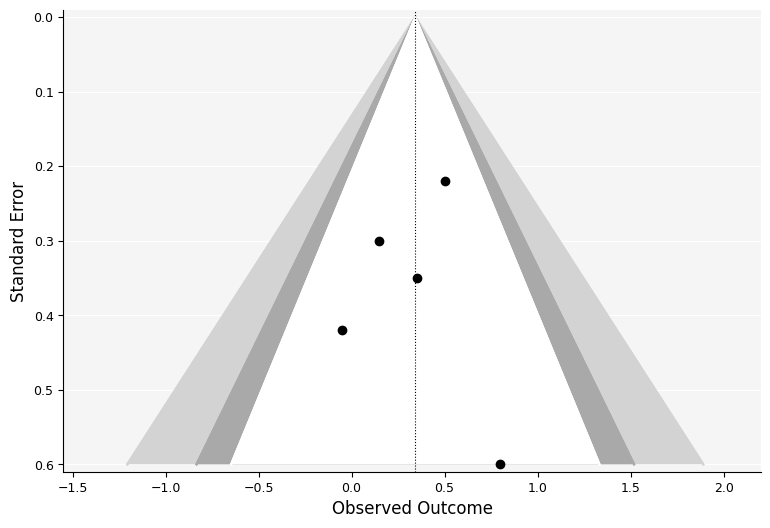

In [ ]:
# Funnel plot

def funnel_plot(data, rma_res=None, es='g', var='SE', figsize=(9, 6), x_adj=(1.5, 1.5),
                y_adj=(0.01, -0.01), xlabel="Observed Outcome", ylabel="Standard Error",
                colors=['whitesmoke', 'lightgray', 'darkgrey',"white"], gridcol='white',
                filename=None, filetype=None, filedpi=100)->None:

    """Function to create a funnel plot for publication bias analysis.

       Parameters
       ----------
       data: DataFrame, required
           Includes columns with effect sizes and variability
           specified as column names in parameters 'es' and 'var'
       rma_res: rma object generated by R metafor, optional
           Includes results of meta-analysis (overall effect)
       ...
    """

    fig, ax = plt.subplots(figsize=figsize)

    # Prepare data
    x = data[es].to_numpy()
    y = np.round(data[var].to_numpy(), 3)
    mid = rma_res['beta'][0][0] if rma_res != None else 0

    ax.set_xlim(np.min(x) - x_adj[0], np.max(x) + x_adj[1])
    ax.set_ylim(np.max(y) + y_adj[0], y_adj[1])
    ax.set_facecolor(color=colors[0])

    ax.grid(axis='y', zorder=0, color=gridcol)

    # Contours
    ax.plot ([mid,(-2.58 * np.max(y))+mid],[0, np.max(y)+mid], linestyle="none", lw=1)
    ax.plot ([mid,(2.58 * np.max(y))+mid],[0, np.max(y)+mid], linestyle="none", lw=1)

    trianglex = [ -2.58 * np.max(y)+mid, mid, 2.58 * np.max(y)+mid]
    triangley = [ np.max(y), 0, np.max(y)]
    for i in range(3):
        ax.plot(trianglex, triangley,color=colors[1], zorder=3)
    ax.fill(trianglex, triangley, colors[1], zorder=3)

    ax.plot ([mid,(-1.96 * np.max(y))+mid], [0, np.max(y)+mid], linestyle="None", lw=1)
    ax.plot ([mid,(1.96 * np.max(y))+mid], [0, np.max(y)+mid], linestyle="None", lw=1)

    trianglex = [ -1.96 * np.max(y)+mid, mid, 1.96 * np.max(y)+mid]
    triangley = [ np.max(y), 0, np.max(y)]
    for i in range(3):
        ax.plot(trianglex, triangley,color=colors[2], zorder=3)
    ax.fill(trianglex, triangley, colors[2], zorder=3)


    ax.plot ([0,(-1.65 * np.max(y))+mid],[0, np.max(y)+mid], linestyle="None", lw=1)
    ax.plot ([0,(1.65 * np.max(y))+mid],[0, np.max(y)+mid], linestyle="None", lw=1)

    trianglex = [ -1.65 * np.max(y)+mid, mid, 1.65 * np.max(y)+mid]
    triangley = [ np.max(y), 0, np.max(y)]
    for i in range(3):
        ax.plot(trianglex, triangley,color=colors[3], zorder=3)
    ax.fill(trianglex, triangley, colors[3], zorder=3)

    ax.axvline(x=mid, color='black', linestyle='dotted', linewidth=0.8, ymin=0, ymax=1, zorder=3)

    # Actual data plotting
    ax.scatter(x, y, marker="o", color="black", zorder=3)

    ax.spines[['top', 'right']].set_visible(False)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    plt.show()

    # Save plot to file (filename and filetype parameters cannot be None or empty)
    if filename and filetype:
        fig.savefig(f"{filename}.{filetype}", dpi=filedpi, format=filetype)
        print('Saving image file')

    return None

funnel_plot(df_merge, rma_res, es='g', var='SE', figsize=(9, 6), x_adj=(1.5, 1.4),
            y_adj=(0.01, -0.01), xlabel="Observed Outcome", ylabel="Standard Error")

In [ ]:
# Print publication bias statistics

print(f"Egger's Regression\nz = {egger['zval'][0]:.3f}, p = {egger['pval'][0]:.3f}\n\n"
      f"Rank Correlation Test\ntau = {rank_test['tau'][0]:.3f}, p = {rank_test['pval'][0]:.3f}\n\n"
      f"Fail-Safe N ({fail_safe['type'][0]}, Target Alpha={fail_safe['alpha'][0]})\nvalue = {fail_safe['fsnum'][0]:.3f}, p = {fail_safe['pval'][0]:.3f}")


Egger's Regression
z = -0.208, p = 0.836

Rank Correlation Test
tau = -0.200, p = 0.817

Fail-Safe N (Rosenthal, Target Alpha=0.05)
value = 5.000, p = 0.013


---